9.12
got gym env up and running w models inside. Generator is SLOW. Try making size much smaller, maybe halving. See if maybe we don't need all that capacity. Right now each forward is .25 seconds, which is untenable. Gameplay look staticky, not as smooth as vids. Can barely tell that we're in control. Had problem w eval() mode on our generator. detrackify seems to have solved it. Although I thought gens would get better after fixing it, though they really didn't. 
TODO: make generator smaller, try for more speed. How can we make gens more robust? They're jumping around all over the place. Maybe make actions discrete when training. Do we just need more training data? How can we wrangle batchnorm? Images need to be clearer and faster! Good we got a minimum prototype up and working-ish.
- On GCP computer, halve size of generator and see if it works w existing dataset.
- On GCP computer, see if we can get gym play working. Probably can't, that's ok. If gen smaller, can easily keep synced w local copy.
- What's up w batchnorm? Dunno. ran a bunch of batches through it, still broken. Don't believe it's running mean--we reloaded model just fine from state dict on GCP, didn't have to run batches through it before doing inference. Perhaps difference in CPU / GPU?
- On local, try to play normally like vid. Should be able to reconstruct. Did so kindof. 

In [1]:
import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from models import *

In [2]:
z_sequential = torch.load("z_seq_sequential_9.10.pt")
norm_z, z_mean, z_max = normalize_sequential(z_sequential)
real_z = torch.tensor(norm_z[10])

torch.Size([1, 100])
torch.Size([1, 100])


In [15]:
g_state_dict = torch.load("netG_updown9.8.torch", map_location=lambda storage, loc: storage)
g = DCGAN_G(IMG_SZ, N_Z, N_CHANNELS, 64, 1).cpu(); 
g.load_state_dict(g_state_dict)

In [16]:
# Decoding generated pred z sequence to images, prepped for np and cv2

ix = 0
bs = 30
z_gen = pad_z(torch.tensor(z_sequential))
preds = []
#g.eval()
with torch.no_grad():
    while ix < z_gen.size(0):
        print(ix)
        batch = z_gen[ix:ix+bs]
        pred = g(batch).cpu().detach().numpy()
        """
        pred = np.transpose(pred, (0, 2, 3, 1)) # prep axis numpy style
        #pred[:, :50,:50, :] = actions_sequential[ix:ix+bs].unsqueeze(1).unsqueeze(1)
        pred = np.uint8(pred*255)
        preds.append(pred)"""
        ix+=bs
        
#preds = np.concatenate(preds, axis=0); print(preds.shape)

0


C:\Users\rugilman\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


30
60
90
120
150
180


KeyboardInterrupt: 

In [22]:
def detrackify(g): 
    """
    Pytorch batchnorm in .eval() was messing things up. This seems to fix it: 
    https://discuss.pytorch.org/t/performance-highly-degraded-when-eval-is-activated-in-the-test-phase/3323/24
    
    """
    for child in g.children():
        for ii in range(len(child)):
            for grandchild in child[ii].children():
                if type(grandchild)==torch.nn.modules.batchnorm.BatchNorm2d:
                    grandchild.track_running_stats = False

In [23]:
g.eval()
detrackify(g)

In [24]:
next_frame = g(pad_z(real_z.unsqueeze(0)))

C:\Users\rugilman\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [25]:
next_frame = next_frame.squeeze(0).permute(1,2,0).detach().numpy()
next_frame = np.uint8(next_frame*255)

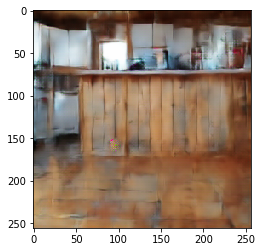

In [26]:
plt.imshow(next_frame)

In [18]:
real_z

tensor([-0.3124,  0.0072,  0.0541, -0.0274, -0.0017, -0.1649,  0.0500,  0.1383,
         0.1881,  0.2104, -0.3725,  0.2957, -0.6691, -0.0282,  0.2776, -0.6246,
         0.5584, -0.2568,  0.3023,  0.1096, -0.3980,  0.2055, -0.1353, -0.8653,
        -0.0992,  0.2527,  0.6630,  0.4264, -0.2143, -0.0968, -0.0952,  0.2565,
         0.2486, -0.3395, -0.2085, -0.1332, -0.0657, -0.1044,  0.0541,  0.2628,
        -0.1642, -0.2678, -0.0861, -0.1969, -0.0061, -0.0128, -0.0022, -0.2480,
         0.0353,  0.0510, -0.2410, -0.2321,  0.3486,  0.1847, -0.2336, -0.2640,
         0.1986, -0.2171,  0.0352, -0.2756, -0.0594, -0.2207,  0.2695,  0.1105,
        -0.0540,  0.2916, -0.0723,  0.1177,  0.3139,  0.1712, -0.0339, -0.1073,
        -0.2966, -0.2460, -0.1321,  0.0624,  0.5381,  0.6064, -0.0830,  0.0961,
         0.2727,  0.2302, -0.3827, -0.0576, -0.0039, -0.0400,  0.2782,  0.1848,
        -0.4389, -0.0726, -0.2593,  0.2100,  0.2659,  0.2177, -0.4212, -0.0746,
        -0.4360, -0.0518, -0.5573, -0.13

In [4]:
START_Z = real_z # grab random latent to start w

# batch size, size of image, size of latent vector z
IMG_SZ = 256
N_Z = 100
N_CHANNELS = 3

num_channels = 3

# rnn takes tiny tiny amount of time. Generator takes .25 seconds each pass.

class test_env(gym.Env):
    def __init__(self):
        
        self.lstm = LSTM()
        self.generator = DCGAN_G(IMG_SZ, N_Z, N_CHANNELS, 64, 1)

        self.lstm.load_state_dict(torch.load("lstm_updown9.10.torch", map_location=lambda storage, loc: storage))
        
        # I believe batch norm stuff was throwing off load. Changed strict to False fixed it
        self.generator.load_state_dict(torch.load("netG_updown9.8.torch", 
                                                  map_location=lambda storage, loc: storage), 
                                       strict=False)
        
        detrackify(self.generator)
        # THese were messing it up!
        self.lstm.eval(); self.generator.eval()
        
        # spaces
        self.action_space = gym.spaces.Box(np.array([-1, 0, 0]), np.array([1, 1, 1]))
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(IMG_SZ, IMG_SZ, 3),dtype=np.uint8)

        self._action_set = [0,1,2,3,4,5]
        #self.action_space = spaces.Discrete(len(self._action_set))
        
        self.reset()

    def reset(self):
        self.z = START_Z
        self.hidden = make_hidden(1, False) # Number of seqs, cuda available
        

    def step(self, action):
        action = ACTION_TO_VALUE[action]
        
        with torch.no_grad():
            action = torch.FloatTensor([action])
            x = torch.cat([action, self.z], dim=0)# only 0 dim here anyways
            x.unsqueeze_(0).unsqueeze_(0) # padding to fit into lstm expectation
            input_package = [x, self.hidden]
            mdn_coefs, self.hidden = self.lstm(input_package)

            # Moving view acrobatics out here to help ONNX
            mdn_coefs[0] = mdn_coefs[0].view(x.size(0), x.size(1), N_GAUSSIANS, N_IN)
            mdn_coefs[1] = mdn_coefs[1].view(x.size(0), x.size(1), N_GAUSSIANS, N_IN)
            mdn_coefs[2] = mdn_coefs[2].view(x.size(0), x.size(1), N_GAUSSIANS, N_IN)

            next_z = sample_mdn(mdn_coefs)[1:] # First item is predicted action
            next_z = torch.tensor(next_z)
            next_frame = self.generator(pad_z(next_z.unsqueeze(0))) # G expects size (1,100,1,1). pad_z puts two ones at end.
            
            self.z = next_z
            # prep frame to show numpy

            next_frame = next_frame.squeeze(0).permute(1,2,0).numpy()
            next_frame = np.uint8(next_frame*255)
            
            return next_frame, 1, False, "info"

    def render(self): # pylint: disable=arguments-differ
        """ Rendering """
        
    def get_action_meanings(self):
        return [ACTION_MEANING[i] for i in self._action_set]
    
    def get_keys_to_action(self):
        KEYWORD_TO_KEY = {
            'UP':      ord('w'),
            'DOWN':    ord('s'),
            'LEFT':    ord('a'),
            'RIGHT':   ord('d'),
            'FIRE':    ord(' '),
        }

        keys_to_action = {}

        for action_id, action_meaning in enumerate(self.get_action_meanings()):
            keys = []
            for keyword, key in KEYWORD_TO_KEY.items():
                if keyword in action_meaning:
                    keys.append(key)
            keys = tuple(sorted(keys))

            assert keys not in keys_to_action
            keys_to_action[keys] = action_id
        return keys_to_action
    
ACTION_MEANING = {
    0 : "NOOP",
    1 : "FIRE",
    2 : "UP",
    3 : "RIGHT",
    4 : "LEFT",
    5 : "DOWN",
}

ACTION_TO_VALUE = {
    0 : 0.0,
    2 : .65,
    5 : -.65
}

In [20]:
env = test_env()
env.reset()
obs, reward, done, info = env.step(0.0); obs.shape

c:\users\rugilman\gym\gym\__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


C:\Users\rugilman\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(256, 256, 3)

In [185]:
env.observation_space.shape[0], env.observation_space.shape[1]

(256, 256)

In [21]:
#env = gym.make("MontezumaRevengeNoFrameskip-v4")

env = test_env()
play(env, zoom = 2, fps=3)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


C:\Users\rugilman\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [85]:
pygame.quit()

In [5]:
import gym
import pygame
import sys
import time
import matplotlib
try:
    matplotlib.use('GTK3Agg')
    import matplotlib.pyplot as plt
except Exception:
    pass


import pyglet.window as pw

from collections import deque
from pygame.locals import HWSURFACE, DOUBLEBUF, RESIZABLE, VIDEORESIZE
from threading import Thread

def display_arr(screen, arr, video_size, transpose):
    #arr_min, arr_max = arr.min(), arr.max()
    #arr = 255.0 * (arr - arr_min) / (arr_max - arr_min)
    pyg_img = pygame.surfarray.make_surface(arr.swapaxes(0, 1) if transpose else arr)
    pyg_img = pygame.transform.scale(pyg_img, video_size)
    screen.blit(pyg_img, (0,0))

def play(env, transpose=True, fps=30, zoom=None, callback=None, keys_to_action=None):

    obs_s = env.observation_space
    assert type(obs_s) == gym.spaces.box.Box
    assert len(obs_s.shape) == 2 or (len(obs_s.shape) == 3 and obs_s.shape[2] in [1,3])

    if keys_to_action is None:
        if hasattr(env, 'get_keys_to_action'):
            keys_to_action = env.get_keys_to_action()
        elif hasattr(env.unwrapped, 'get_keys_to_action'):
            keys_to_action = env.unwrapped.get_keys_to_action()
        else:
            assert False, env.spec.id + " does not have explicit key to action mapping, " + \
                          "please specify one manually"
    relevant_keys = set(sum(map(list, keys_to_action.keys()),[]))
    
    if transpose:
        video_size = env.observation_space.shape[1], env.observation_space.shape[0]
    else:
        video_size = env.observation_space.shape[0], env.observation_space.shape[1]

    if zoom is not None:
        video_size = int(video_size[0] * zoom), int(video_size[1] * zoom)

    pressed_keys = []
    running = True
    env_done = True

    screen = pygame.display.set_mode(video_size)
    clock = pygame.time.Clock()

    while running:
        if env_done:
            env_done = False
            obs = env.reset()
        else:
            action = keys_to_action.get(tuple(sorted(pressed_keys)), 0)
            prev_obs = obs
            obs, rew, env_done, info = env.step(action)
            if callback is not None:
                callback(prev_obs, obs, action, rew, env_done, info)
        if obs is not None:
            if len(obs.shape) == 2:
                obs = obs[:, :, None]
            if obs.shape[2] == 1:
                obs = obs.repeat(3, axis=2)
            display_arr(screen, obs, transpose=transpose, video_size=video_size)

        # process pygame events
        for event in pygame.event.get():
            # test events, set key states
            if event.type == pygame.KEYDOWN:
                if event.key in relevant_keys:
                    pressed_keys.append(event.key)
                elif event.key == 27:
                    running = False
            elif event.type == pygame.KEYUP:
                if event.key in relevant_keys:
                    pressed_keys.remove(event.key)
            elif event.type == pygame.QUIT:
                running = False
            elif event.type == VIDEORESIZE:
                video_size = event.size
                screen = pygame.display.set_mode(video_size)

        pygame.display.flip()
        clock.tick(fps)
    pygame.quit()


pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


C:\Users\rugilman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\rugilman\AppData\Local\Continuum\anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rugilman\AppData\Local\Continuum\anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rugilman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\rugilman\AppData\Local\Continuum\anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C